<h4 align='right'> $\textit{Aurélien Castre, Eliott Tourtois}$ </h4>
<h1 align='center'> $\textbf{Filtrage - MACS207b}$ </h1>
$\newline$

# Ce qu'il reste à faire :

- tweak kmeans
- comparer les deux méthodes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.integrate import odeint
from scipy import signal
from sklearn.cluster import KMeans

$\textbf{Question 1}$

$\tau$ suit une loi exponentielle de paramètre $\mu$, on peut donc facilement calculer $h$ :

$$ h(s)=\frac{f(s)}{1-F(s)}= \left\{
    \begin{array}{ll}
        \frac{\mu\exp(-\mu s)}{\exp(-\mu s)} & \mbox{si } s \in \mathbb{R}_+ \\
        0 & \mbox{sinon.}
    \end{array}
\right. = \mu \mathbb{1}_{\mathbb{R}_+}(s) $$

$\textbf{Question 2}$

Pour simuler $N$ sur l'intervalle de temps $[0, T]$, on commence par tirer $\tau$ selon une loi exponentielle de paramètre $\mu$. Ensuite, on tire les instants de saut de $N_a$ selon une loi exponentielle de paramètre $a$ en partant de 0 et tant qu'on ne dépasse pas la valeur de $\tau(\omega)$. Enfin, on tire les instants de saut de $N_b$ selon une loi exponentielle de paramètre $b$ en partant de $\tau(\omega)$ et tant qu'on ne dépasse pas $T$.

In [2]:
def N(mu, a, b, end, rng = np.random.default_rng(None)) :
    """Simulate the trajectory of N between 0 and T

    Parameters
    ----------
    mu : float
        The parameter of the exponential distribution of tau
    a : float
        The parameter of the Poisson process before tau
    b : float
        The parameter of the Poisson process after tau
    end : float
        The end of the simulation
    rng : Generator, optional
        A Random Number Generator for reproducibility
        (default is np.random.default_rng(None))

    Returns
    -------
    float
        The value of tau in the simulation
    list
        The list of arrival times of the Poisson process before tau
    list
        The list of arrival times of the Poisson process after tau
        (empty if tau > T)
    """
    
    # Simulate tau using inverse transform sampling
    u = rng.uniform()
    tau = -1/mu*np.log(u)
    
    # Simulate the first Poisson process
    Tas = []
    t = 0
    while t <= min(tau, end) :
        u = rng.uniform()
        t += -1/a*np.log(u)
        Tas.append(t)
    Tas.pop()
    
    # Simulate the second Poisson process
    Tbs = []
    t = tau
    while t <= end :
        u = rng.uniform()
        t += -1/b*np.log(u)
        Tbs.append(t)
    # Pop the last arrival time (which might be greater that T) only
    # if Tbs is not empty (which is the case when tau > T)
    if Tbs:
        Tbs.pop()
        
    return tau, Tas, Tbs

In [3]:
def plotN(tau, Tas, Tbs, end, z_estimate = None, kmeans_estimate = None) :
    """Plots the graph of the process N

    Parameters
    ----------
    tau : float
        The value of the random time after which the rate changes
    Tas : list
        The list of arrival times of the Poisson process before tau
    Tbs : list
        The list of arrival times of the Poisson process after tau
    end : float
        The end of the simulation
    z_estimate : float, optional
        Plots the estimated value of tau using Z
        (defaults is None)
    kmeans_estimate : tuple, optional
        Plots the estimated interval of tau using kmeans
        (defaults is None)
    """
    
    T = Tas + Tbs
    plt.figure(figsize = (16,6))
    plt.step([0] + T + [end], [0] + [i for i in range(len(T) + 1)], label=r'$N(t)$')
    
    if tau <= end:
        plt.vlines(tau, 0, len(T) + 1, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    else:
        plt.vlines(0, 0, 0, color='r', label=r'$\tau \approx $' + str(tau)[:4])
    
    if kmeans_estimate :
        plt.fill_betweenx(np.linspace(0,len(T) + 1), kmeans_estimate[0], kmeans_estimate[1], alpha = 0.2,\
                          color = 'g', label = "kmeans estimate")
    if z_estimate :
        plt.vlines(z_estimate, 0, len(T) + 1, color='g', label=r'$\hat{\tau} \approx $' + str(z_estimate)[:4])
    
    plt.legend(loc = 'right', fontsize = 18)
    plt.xticks(range(end + 1))
    plt.grid()

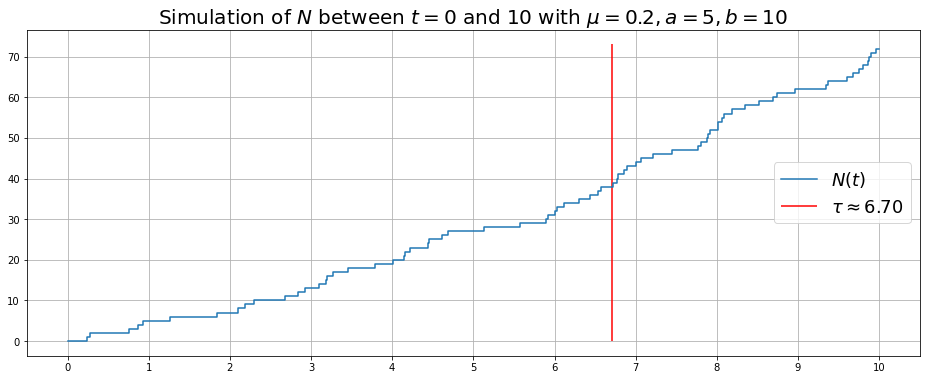

In [4]:
seed = 2
# 5 c'est très mauvais pour kmeans, 3 tau est loin, 4 tau est au tout début, 2 Z est pas ouf
rng = np.random.default_rng(seed)

mu = 0.2
a = 5
b = 10
end = 10

tau, Tas, Tbs = N(mu, a, b, end, rng)
plotN(tau, Tas, Tbs, end)
plt.title(rf"Simulation of $N$ between $t = 0$ and {end} with $\mu = {mu}, a = {a}, b = {b}$", fontsize = 20)
plt.show()

$\textbf{Question 3}$

Pour calculer $\hat Z$, on utilise le résultat de la question 10 de l'exercice 2.2 du polycopié, *i.e.*
$$\hat{Z}(t) = \hat{Z}(T_n) + \int_{T_n}^t \left(h(s) - (b-a)\hat{Z}(s)\right)\left(1-\hat{Z}(s)\right)\mathrm{d}s$$

On remarque qu'en dehors des instants de sauts, $\hat Z$ est $\mathcal{C}^1$. On peut donc dériver l'équation ci-dessus pour obtenir l'équation différentielle ci-dessous que nous résoudrons numériquement entre chaque instant de saut :
$$\frac{\mathrm{d}}{\mathrm{d}t}\hat{Z}(t) = \left(\mu - (b-a)\hat{Z}(t)\right)\left(1-\hat{Z}(t)\right)$$

Quant à la valeur aux instants de sauts, elle est donnée par la formule
$$\hat{Z}(T_n) - \hat{Z}(T_n^-) = \frac{(b-a)\hat{Z}(T_n^-)\left(1-\hat{Z}(T_n^-)\right)}{a + (b-a)\hat{Z}(T_n^-)}$$

Pour approximer $\hat{Z}(T_n^-)$, on choisira simplement le dernier point de la simulation numérique qui précède le saut.

Dans la suite du code, `Z` désignera $\hat Z$.

In [5]:
def Z(mu, a, b, end, T, num = 50) :
    """Computes an approximation of the conditional expectation Z(t) for
    all t between 0 and T

    Parameters
    ----------
    mu : float
        The parameter of the exponential distribution of tau
    a : float
        The parameter of the Poisson process before tau
    b : float
        The parameter of the Poisson process after tau
    end : float
        The end of the simulation
    T : list
        The arrival times of N
    num : int, optional
        The number of points used to approximate Z between any two arrival times
        (default is 50)

    Returns
    -------
    list
        The list of points used to plot Z (linspaces + arrival times)
    numpy array
        1D array of values of Z
    """

    dZ = lambda y, t : (mu - (b - a)*y)*(1 - y)
    z = [0]
    ts = []
    jumps = []
    for i in range(len(T) - 1):
        t = np.linspace(T[i], T[i+1], num)[:-1]
        ts += list(t)
        # Solve the differential equation between two points
        z = np.append(z, odeint(dZ, z[-1], t).flatten())
        zjump = (b-a)*z[-1]*(1 - z[-1])/(a + (b-a)*z[-1])
        # Add the jump
        z = np.append(z, zjump + z[-1])
        jumps.append(zjump + z[-1])
        ts.append(T[i+1])

    return ts, z[1:], jumps

In [6]:
def plotZ(ts, z, tau, end) :
    """Plots the graph of the process N

    Parameters
    ----------
    tau : float
        The value of the random time after which the rate changes
    Tas : list
        The list of arrival times of the Poisson process before tau
    Tbs : list
        The list of arrival times of the Poisson process after tau
    end : float
        The end of the simulation
    """
    
    plt.figure(figsize = (16,6))
    plt.plot(ts, z, label=r'$\hatZ (t) = \mathbb{E}\left[\mathbb{1}_{\tau \leq t}|\mathcal{F}^N_t\right]$')
    plt.xticks(range(end + 1))
    if tau <= end:
        plt.vlines(tau, 0, 1, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    else:
        plt.vlines(0, 0, 0, color='r', label=rf'$\tau \approx $' + str(tau)[:4])
    plt.legend(fontsize = 15)
    plt.grid()

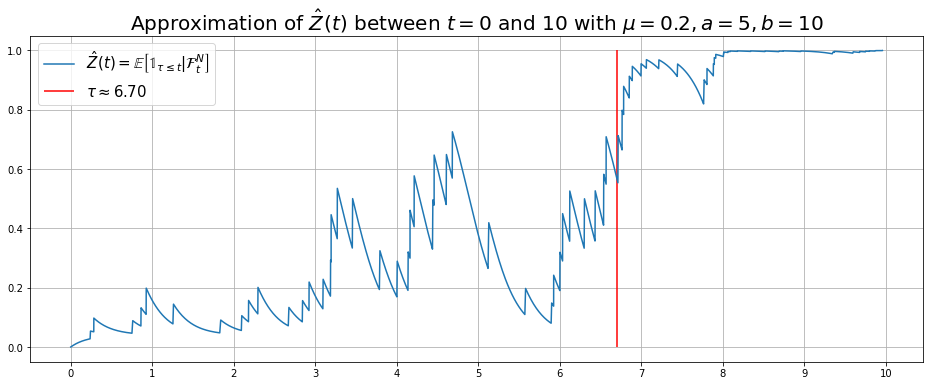

In [7]:
T = [0] + Tas + Tbs
ts, z, jumps = Z(mu, a, b, end, T)

plotZ(ts, z, tau, end)
plt.title(rf"Approximation of $\hatZ (t)$ between $t = 0$ and {end} with $\mu = {mu}, a = {a}, b = {b}$", fontsize = 20)
plt.show()

Il faut ensuite calculer l'approximation de $\tau$. Pour cela, nous proposons une méthode en deux temps.
- Il faut d'abord lisser la courbe de $\hat{Z}$ pour ignorer les sauts ainsi que les erreurs qui peuvent être commises du fait du caractère aléatoire des données (par malchance, on peut avoir beaucoup de sauts rapprochés avant $\tau$, ce qui conduirait à une augmentation abrupte de $\hat{Z}$). L'objecif est de se rapprocher de l'allure d'une sigmoïde ou d'une indicatrice.
- Ensuite, il faut choisir l'abscisse qui approximera le mieux $\tau$. Nous proposons encore deux méthodes :
    - fixer un seuil (par exemple 0.5) est mesurer le premier dépassement de ce seuil par la courbe lissée,
    - dériver la coubre lissée et choisir l'abscisse du maximum.
    
Dans la suite de la réponse, on définira une méthode d'évalutation pour ensuite choisir la meilleure technique d'approximation.

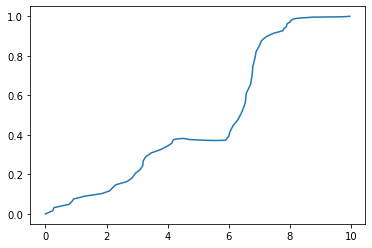

In [8]:
window = signal.hamming(800)
zfiltered = signal.filtfilt(window, 1, z)
plt.plot(ts,zfiltered/np.max(zfiltered))

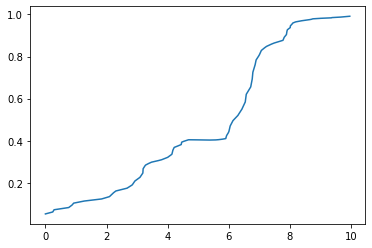

In [9]:
d, c = signal.butter(1, 0.001)
zsmo = signal.filtfilt(d, c, z)
plt.plot(ts, zsmo)

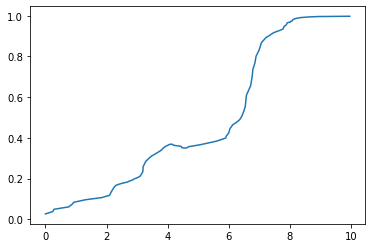

In [10]:
plt.plot(ts, signal.savgol_filter(z, 801, 1))

In [11]:
def treshold_estimate(ts, zfiltered, tresh) :
    times = []
    for i in range(len(zfiltered)) :
        if ((zfiltered[i] > tresh) and (zfiltered[i-1] <= tresh)):
            times.append(ts[i])
    if len(times) > 1:
        return (times[-1] + times[-2])/2
    else :
        return(times[0])

In [12]:
def zfilter(z, name) :
    if name == 'hamming' :
        window = signal.hamming(800)
        zfiltered = signal.filtfilt(window, 1, z)
        return zfiltered/np.max(zfiltered)
    if name == 'butterworth' :
        d, c = signal.butter(1, 0.001)
        return signal.filtfilt(d, c, z)
    if name == 'savgol' :
        return signal.savgol_filter(z, 801, 1)
    else :
        print("Wrong filter name.")

In [13]:
# Fonction pour tester la qualité des résultats

def evaluate_treshold(zfilter_name, n, mu, a, b, tresh = 0.5, end = 2/mu, rng = np.random.default_rng(None)) :
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(mu, a, b, 2*end, rng)
        ts, z, jumps = Z(mu, a, b, 2*end, [0] + Tas + Tbs, num = 50) #on simule jusqu'à 2*end pour être sûrs de choper le moment où ça explose
        zfiltered = zfilter(z, zfilter_name)
        htau = treshold_estimate(ts, zfiltered, tresh)
        error += np.abs(htau - tau)
    return error/n

In [14]:
# Fonction pour tester la qualité des résultats

def evaluate_gradient(zfilter_name, n, mu, a, b, tresh = 0.5, end = 2/mu, rng = np.random.default_rng(None)) :
    error = 0
    for i in range(n) :
        tau = 10
        while tau >= 10 :
            tau, Tas, Tbs = N(mu, a, b, 2*end, rng)
        ts, z, jumps = Z(mu, a, b, 2*end, [0] + Tas + Tbs, num = 50) #on simule jusqu'à 2*end pour être sûrs de choper le moment où ça explose
        zfiltered = zfilter(z, zfilter_name)
        htau = ts[np.argmax(np.gradient(zfiltered))]
        error += np.abs(htau - tau)
    return error/n

In [15]:
%%timeit
print(evaluate_treshold('butterworth', 10, 0.2, 5, 10))

0.7285836812112869
1.1300366285801684
1.1371667007006894
1.1932397410618834
0.776346061416806
1.1957634112231108
0.7822221703408612
0.8953997790293251
344 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
print(evaluate_treshold('hamming', 10, 0.2, 5, 10))

0.5657158011805301
1.1719648447552287
1.1522353271930612
1.0548579230838724
0.8573857142840577
1.2526176407771863
0.8790200289150807
1.7398796059373076
715 ms ± 47.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
print(evaluate_treshold('savgol', 10, 0.2, 5, 10))

0.9843872857544465
0.7042030079665866
0.9040303584506347
1.096424726713548
0.999177146966612
0.47216085047386
1.4640088570703227
0.8910355140129452
532 ms ± 77.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


conclusion de cette partie : butterworth est le plus rapide

In [18]:
rng = np.random.default_rng(42)
evaluate_gradient('savgol', 1000, 0.2, 5, 10, rng = rng)

1.1971277632740809

In [19]:
rng = np.random.default_rng(42)
evaluate_treshold('hamming', 1000, 0.2, 5, 10, rng = rng)

1.0137642197008203

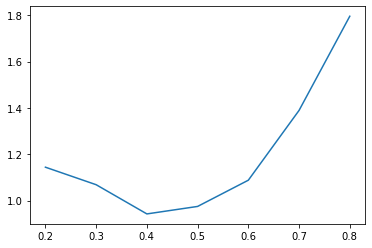

In [20]:
tresholds = np.arange(0.2, .8, 0.1)
errors = []
for tresh in tresholds :
    errors.append(evaluate_treshold('savgol', 50, 0.2, 5, 10, tresh = tresh))
plt.plot(tresholds, errors)

In [21]:
rng = np.random.default_rng(42)
evaluate_treshold('butterworth', 1000, 0.2, 5, 10, rng = rng, tresh = 0.4)

0.8926250208500522

$\textbf{Question 4}$

On commence par une application naïve de l'algorithme.

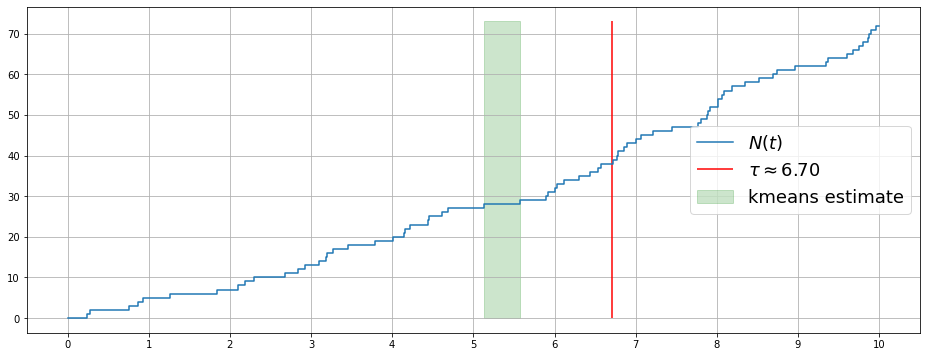

In [22]:
kmeans = KMeans(n_clusters=2, n_init=10, init='k-means++').fit(np.array(T).reshape(-1, 1))
# , random_state=np.random.RandomState(seed)
pred = kmeans.predict(np.array(T).reshape(-1, 1))
p = abs((1-pred[0])-pred)

plotN(tau, Tas, Tbs, end, kmeans_estimate = (T[p.sum()-1], T[p.sum()]))

On change maintenant l'initialisation en utilisant la valeur de $\mu$.

In [23]:
m = np.array(T).mean()
def init(X, n_clusters, random_state):
    # We have only one feature :
    X = X.flatten() + m
    i = len([x for x in X if x < 1/mu])
    n = len(X)
    return [X[random_state.randint(i, n)]-m], [X[random_state.randint(0, i)]-m]

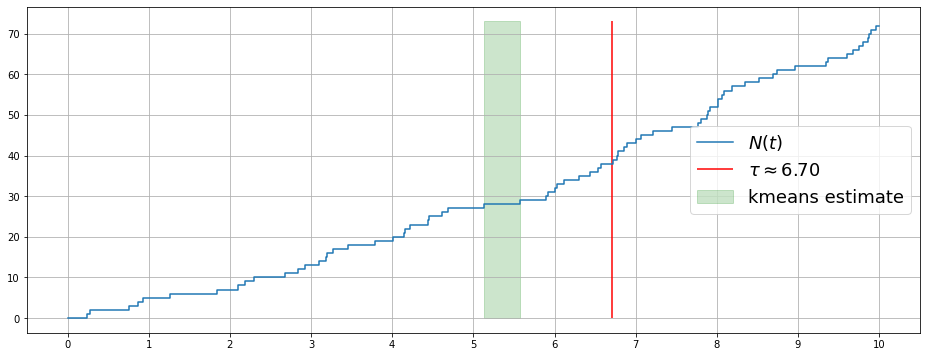

In [24]:
kmeans = KMeans(n_clusters=2, n_init=10, init=init).fit(np.array(T).reshape(-1, 1))
pred = kmeans.predict(np.array(T).reshape(-1, 1))
p = abs((1-pred[0])-pred)

plotN(tau, Tas, Tbs, end, kmeans_estimate = (T[p.sum()-1], T[p.sum()]))

$\textbf{Question 5}$
- Pour k means il choisit un des sauts qui lui apparaissent bons mais aléatoirement
- k means n'utilise pas les données d'entrée (a,b,$\mu$)
- Pour l'autre méthode, on peut regarder la stabilité qui suit et donc choisir le seul truc stable